# Exploratory Analysis
---

This code imports zipped data files from an S3 bucket, determines the shape and size of the data frame (Pandas), detects outliers/NAN/Null values, calculates collumn-wise mean/median/mode/stddev, and performs some correlation analysis on the variables.

# Dependencies & Functions
---

In [21]:
import pandas as pd
import boto3
import botocore
import sagemaker
import numpy as np
from eda import eda
import matplotlib.pyplot as plt

#Globals
#Filename prefix, for storing artifacts
filename_prefix = 'normal_02_'

# Input dataset filename name here
data_filename = "SWaT_Dataset_Normal_v1_02.csv"

# Import Data
---

In [22]:
# Import dataset from S3 Bucket

bucket = "exploratoryanalysis-swat"             # Bucket location for working directory
prefix = "analysis_artifacts"                   # Folder location for working directory

# S3 bucket where the original data is downloaded and stored.
downloaded_data_bucket = "exploratoryanalysis-swat"    # Bucket location for data directory
downloaded_data_prefix = "dataset_unzipped"            # Folder location of data files

# Housekeeping, sagemaker gets execution role and reigon from this sagemaker instance
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# Check bucket existence and permissions
def check_bucket_permission(bucket):
    # check if the bucket exists
    permission = False
    try:
        boto3.Session().client("s3").head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(
            "Hey! You either forgot to specify your S3 bucket"
            " or you gave your bucket an invalid name!"
        )
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "403":
            print(f"Hey! You don't have permission to access the bucket, {bucket}.")
        elif e.response["Error"]["Code"] == "404":
            print(f"Hey! Your bucket, {bucket}, doesn't exist!")
        else:
            raise
    else:
        permission = True
    return permission


if check_bucket_permission(bucket):
    print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")
if check_bucket_permission(downloaded_data_bucket):
    print(f"Downloaded training data will be read from s3://{downloaded_data_bucket}/{downloaded_data_prefix}")
# Future development: expand for more data upload options, perhaps a filepath instead

Training input/output will be stored in: s3://exploratoryanalysis-swat/analysis_artifacts
Downloaded training data will be read from s3://exploratoryanalysis-swat/dataset_unzipped


# Classify & Organize
---

In [23]:
# Organize and qualify data

# Download S3 data file to Sagemaker space
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/{data_filename}", data_filename)

# Read file into Pandas Dataframe 
sensor_data = pd.read_csv(data_filename)

# Establish Shape of raw sensor data
raw_data_shape = sensor_data.shape

# Clean Data
---

In [24]:
# Locate NAN values and store indicies
nan_values = sensor_data[sensor_data.isna().any(axis=1)]
if nan_values.empty:
    pass
else:
    # Determine what we want to do with the missing fields
    print('There are NAN values in the data')
    
    
# I already know that there is a misspelling of the word "Attack" that reads "A ttack" which will need to be cleaned in the attack version of the dataset.
# This cleaning has been performed within the .csv direclty

# I also see another issue where the SWaT Attack dataset does not have the P1, P2, ... P5 headers above the individual collumns
# This has been corrected by removing the process headers

# Data Statistics
---

In [26]:
# Determine mean, median, std dev, etc. of each collumn
data_statistics = sensor_data.describe()
#print("Dataset statistics for each column:")
pd.set_option('display.max_columns', None)
display(data_statistics)

filename = filename_prefix + 'data_statistics.csv'
data_statistics.to_csv(filename)

s3.upload_file(
    Filename=filename,
    Bucket=bucket,
    Key=f"{prefix}/{filename}"
)

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
count,293769.000000,293769.000000,293769.000000,293769.000000,293769.0,293769.000000,293769.000000,293769.000000,293769.000000,293769.000000,293769.0,293769.0,293769.000000,293769.0,293769.000000,293769.0,293769.000000,293769.000000,293769.000000,293769.000000,293769.000000,293769.000000,293769.000000,293769.0,293769.000000,293769.000000,293769.000000,293769.000000,293769.000000,293769.0,293769.0,293769.0,293769.0,293769.0,293769.000000,293769.000000,293769.000000,293769.000000,293769.000000,293769.000000,293769.000000,293769.000000,293769.0,293769.0,293769.000000,293769.000000,293769.000000,293769.000000,293769.0,293769.000000,293769.0
mean,1.845282,591.260622,1.718401,1.749153,1.0,266.224838,8.380223,327.544143,1.832543,1.745957,1.0,1.0,1.747254,1.0,1.747254,1.0,16.625906,1.842312,907.568287,1.005494,1.802743,1.019910,1.024628,1.0,1.827575,148.803490,162.214554,1.716995,892.597795,1.0,2.0,1.0,1.0,2.0,7.892930,149.429499,268.575824,12.188184,1.727327,1.285329,0.735541,0.307196,2.0,1.0,250.794220,1.117479,189.830229,0.014218,1.0,1.007846,1.0
std,1.134811,112.787675,0.458905,0.433501,0.0,2.730337,0.032543,5.512685,1.058303,0.443611,0.0,0.0,0.434587,0.0,0.434587,0.0,6.749867,0.820525,71.126965,0.110008,0.414233,0.168437,0.195160,0.0,0.377750,0.003503,4.105470,0.011476,59.117718,0.0,0.0,0.0,0.0,0.0,0.013365,4.601930,3.367319,0.655832,0.011849,0.019504,0.004121,0.001635,0.0,0.0,2.780814,0.103822,2.497145,0.148031,0.0,0.088231,0.0
min,0.000000,486.420200,0.000000,1.000000,1.0,259.741100,8.314407,312.278900,0.000000,0.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,0.000000,0.000000,785.135300,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,148.745500,153.781100,1.685323,775.070500,1.0,2.0,1.0,1.0,2.0,7.864522,142.348100,259.741100,10.535760,1.695206,1.202254,0.725155,0.301701,2.0,1.0,245.177500,0.816967,184.856400,0.000000,1.0,1.000000,1.0
25%,0.000000,509.932600,1.000000,1.000000,1.0,264.483500,8.358626,325.147400,0.640630,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,19.639540,2.210806,836.884800,1.000000,2.000000,1.000000,1.000000,1.0,2.000000,148.803200,158.395300,1.710313,849.128400,1.0,2.0,1.0,1.0,2.0,7.882146,145.860000,266.374000,11.843120,1.720200,1.272064,0.732580,0.306569,2.0,1.0,248.782400,1.057252,188.060800,0.000000,1.0,1.000000,1.0
50%,2.489191,526.654200,2.000000,2.000000,1.0,266.406000,8.370802,329.530900,2.441547,2.000000,1.0,1.0,2.000000,1.0,2.000000,1.0,19.834820,2.214777,921.077900,1.000000,2.000000,1.000000,1.000000,1.0,2.000000,148.803200,162.907000,1.717746,894.232200,1.0,2.0,1.0,1.0,2.0,7.892400,148.731100,268.456800,12.112280,1.728531,1.284873,0.734885,0.306761,2.0,1.0,250.576800,1.105309,189.566800,0.000000,1.0,1.000000,1.0
75%,2.592960,672.949300,2.000000,2.000000,1.0,267.367300,8.392912,331.248400,2.448851,2.000000,1.0,1.0,2.000000,1.0,2.000000,1.0,19.975670,2.217852,965.217300,1.000000,2.000000,1.000000,1.000000,1.0,2.000000,148.803200,164.188700,1.724922,937.144300,1.0,2.0,1.0,1.0,2.0,7.901051,150.704900,270.828000,12.612150,1.735709,1.300243,0.737957,0.308362,2.0,1.0,252.675600,1.169384,191.537400,0.000064,1.0,1.000000,1.0
max,2.745092,817.556500,2.000000,2.000000,1.0,272.526300,8.468855,341.245800,2.487810,2.000000,1.0,1.0,2.000000,1.0,2.000000,1.0,20.539090,2.358774,1014.163000,2.000000,2.000000,2.000000,2.000000,1.0,2.000000,148.851300,172.366100,1.747862,1002.897000,1.0,2.0,1.0,1.0,2.0,7.925084,163.496500,283.356800,13.957960,1.757754,1.361983,0.745895,0.312014,2.0,1.0,257.289800,1.890238,195.655000,1.746131,1.0,2.000000,1.0


In [27]:
# What are the unique values and counts for each categorical column
unique_values = sensor_data.nunique(axis=0)

#Number of unique values for each column in dataset:
filename = filename_prefix + 'unique_values_count.csv'
unique_values.to_csv(filename)

s3.upload_file(
    Filename=filename,
    Bucket=bucket,
    Key=f"{prefix}/{filename}"
)

# Which columns have only a single unique value? (Constants)
constant_columns = unique_values.where(unique_values==1).dropna(how='all')

filename = filename_prefix + 'constant_values.csv'
constant_columns.to_csv(filename)

s3.upload_file(
    Filename=filename,
    Bucket=bucket,
    Key=f"{prefix}/{filename}"
)

In [ ]:
# Exploratory Data Analysis Function
eda(df=sensor_data)

# Outliers
---

In [28]:
# Locate and classify outliers
import numpy as np
from scipy import stats

# The collumns include two objects: a timestamp and a string. These cannot be analyzed for outliers, and will be removed by selecting only columns with numbers
numerical_sensor_data = sensor_data.select_dtypes(include='number')

# Z Score tells us how many standard deviations each value is from the mean. Anything outside of 3 STD deviations is an outlier and anything outside 2 is in the farthest 5% and could be cut
z_scores = numerical_sensor_data.apply(stats.zscore)

pd.set_option('display.max_columns', None)
#display(z_scores.head())

filename = filename_prefix + 'z_scores_matrix.csv'
z_scores.to_csv(filename)

s3.upload_file(
    Filename=filename,
    Bucket=bucket,
    Key=f"{prefix}/{filename}"
)

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [29]:
# Interquartile Range (IQR) is another way to classify outliers. 
# IQR determines the range between the 25th and 75th percentile
# Then, anything that lies 1.5*(range) above or below these quartiles is considered an outlier
# If the data value is lower than the lower range or larger than the upper range, store the index of the value.
# Then count the number of outliers

IQR = data_statistics.loc['75%'] - data_statistics.loc['25%']
IQR = IQR.to_frame()
IQR = IQR.transpose()

# Define lower and upper ranges for each variable. Statistics does not run on timestamp or string objects. Only columns with numerical values.
lower_range = data_statistics.loc['25%'] - 1.5 * IQR
upper_range = data_statistics.loc['75%'] + 1.5 * IQR

# The format of a query needs to be "column label <query condition> @<variable name to be compared against>"
# 'FIT101<@aa' where aa is the variable that holds the limit value for this iteration
lower_queries = ['{}<@aa'.format(k) for k in lower_range.columns]
upper_queries = ['{}>@aa'.format(k) for k in upper_range.columns]

jj = 0
tot_upper_outl = 0
tot_lower_outl = 0
for column in IQR:
    # Lower boundary check
    aa = lower_range.iat[0,jj]                                        # ex: FIT101
    lower_outliers = numerical_sensor_data.query(lower_queries[jj])   # ex: 'FIT101<@aa'
    if not lower_outliers.empty:
        print('Condition that triggered the IQR outlier: ', lower_queries[jj], aa)
        print('Number of "less than" outliers', lower_outliers.shape[0], '\n')
        tot_lower_outl += lower_outliers.shape[0]
    
    # Upper Boundary Check
    aa = upper_range.iat[0,jj]                                        # ex: FIT101
    upper_outliers = numerical_sensor_data.query(upper_queries[jj])   # ex: 'FIT101>@aa'
    if not upper_outliers.empty:
        print('Condition that triggered the IQR outlier: ', upper_queries[jj], aa)
        print('Number of "greater than" outliers', upper_outliers.shape[0], '\n')
        tot_upper_outl += upper_outliers.shape[0]
    jj += 1
    
print('Total number of outliers: ', tot_lower_outl+tot_upper_outl)

Condition that triggered the IQR outlier:  AIT201<@aa 260.15779999999995
Number of "less than" outliers 14 

Condition that triggered the IQR outlier:  AIT201>@aa 271.693
Number of "greater than" outliers 36 

Condition that triggered the IQR outlier:  AIT202>@aa 8.444341000000003
Number of "greater than" outliers 11796 

Condition that triggered the IQR outlier:  AIT203<@aa 315.9959
Number of "less than" outliers 8145 

Condition that triggered the IQR outlier:  AIT203>@aa 340.3999
Number of "greater than" outliers 29 

Condition that triggered the IQR outlier:  DPIT301<@aa 19.135345
Number of "less than" outliers 58312 

Condition that triggered the IQR outlier:  DPIT301>@aa 20.479865000000004
Number of "greater than" outliers 7 

Condition that triggered the IQR outlier:  FIT301<@aa 2.2002369999999996
Number of "less than" outliers 52350 

Condition that triggered the IQR outlier:  FIT301>@aa 2.228421000000001
Number of "greater than" outliers 8508 

Condition that triggered the IQR

# Correlation
---

In [30]:
# Correlation analysis
# Are there any correlations between the different columns in the data?
# Display correlation matrix

# First, drop all the columns with constant values. These will not impact a correlation matrix.
variable_sensor_data = sensor_data.drop(constant_columns.index, axis=1)

correlation_matrix = variable_sensor_data.corr()
pd.set_option('display.max_columns', None)
#display(correlation_matrix.head())

# Upload correlation matrix CSV to S3 Artifacts
filename = filename_prefix + 'correlation_matrix.csv'
correlation_matrix.to_csv(filename)

s3.upload_file(
    Filename=filename,
    Bucket=bucket,
    Key=f"{prefix}/{filename}"
)

<Figure size 640x480 with 0 Axes>

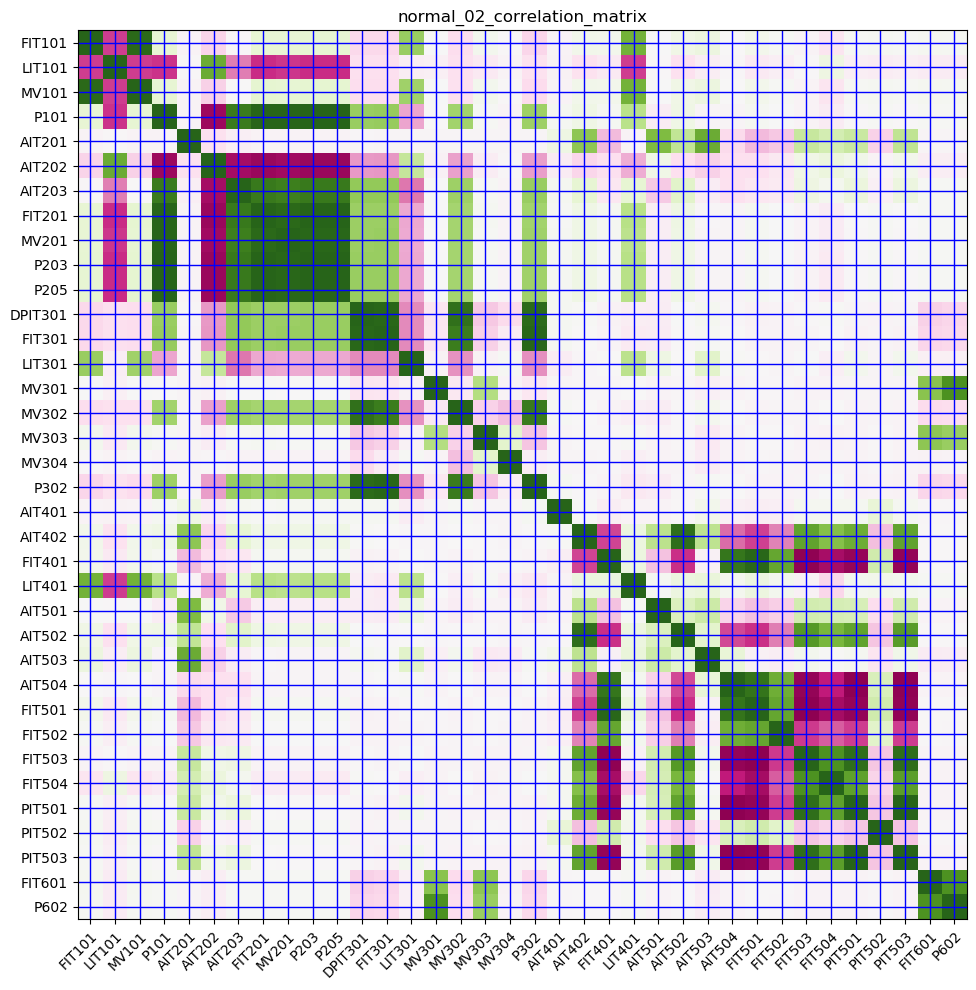

In [31]:
# Room to add more correlation techniques

fig, ax = plt.subplots()

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(correlation_matrix)));
ax.set_yticks(np.arange(len(correlation_matrix)));
ax.minorticks_off()
ax.grid(which='major', color='b', linestyle='-', linewidth=1, visible=True);
ax.set_xticklabels(correlation_matrix.columns);
ax.set_yticklabels(correlation_matrix.index);

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");

title = filename_prefix + "correlation_matrix"
filename = title + '.png'

ax.set_title(title)
fig.set_figwidth(10);
fig.set_figheight(10);
fig.tight_layout();
im = ax.imshow(correlation_matrix, cmap='PiYG');

plt.show()

plt.savefig(filename)
s3.upload_file(
    Filename=filename,
    Bucket=bucket,
    Key=f"{prefix}/{filename}"
)

# Plots

<Figure size 640x480 with 0 Axes>

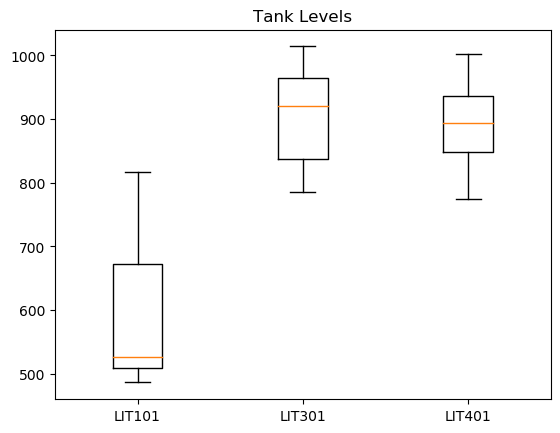

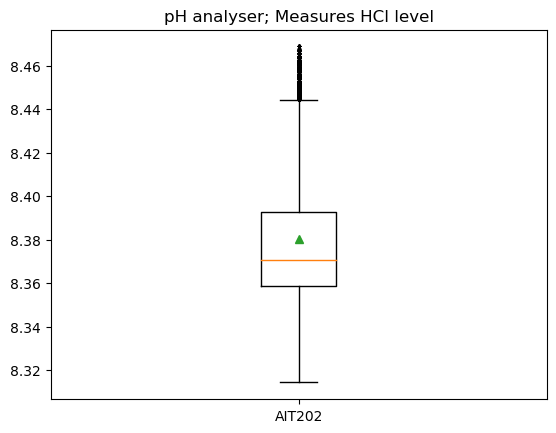

In [32]:
# Box Plot
# We need to decide which values box plots are appropriate for. Numerical data with sufficient variation (not a binary 1 or 0)
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.set_title('Tank Levels')
ax1.boxplot([sensor_data.LIT101,sensor_data.LIT301, sensor_data.LIT401])
ax1.set_xticklabels(['LIT101','LIT301','LIT401'])
plt.show(fig1)

fig2, ax2 = plt.subplots()
ax2.set_title('pH analyser; Measures HCl level')
flierprops = dict(marker='*', markerfacecolor='blue', markersize=2,
                  linestyle='none')
ax2.boxplot([sensor_data.AIT202], showmeans=True, flierprops=flierprops)
ax2.set_xticklabels(['AIT202'])
plt.show(fig2)


In [ ]:
# Plot data for visual representation
# Note: The quantity of data means it takes a very long time to run. We might want to get a larger instance before doing heavy plotting.
import matplotlib.pyplot as plt
plt.plot(sensor_data.Timestamp.loc[1:1000],sensor_data.LIT101.loc[1:1000])
plt.show()